In [1]:
from itertools import chain
import pandas as pd
from collections import defaultdict

from math import floor, ceil, log10
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import sys
import os
ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(ROOT)

In [3]:
from gear_models.model_library import GearModelLibrary, validate_gear_types
from gear_models.gear_mapping import gear_mapper

In [4]:
gml = GearModelLibrary(os.path.join(ROOT, 'models'), verbose=True)

Adding effort model Fuel Economy - Sendai Bay small scale trawl
Adding effort model Fishing Days by vessel size - Sendai Bay small scale trawl
Adding gear intensity model small scale bottom trawl - Sendai Bay
Adding effort model Effort intensity for 27.5x5 m gillnets in terms of square-meter-hours
Adding gear intensity model Gear intensity for 200-mm mesh 0.7mm dia monofilament gillnets
Adding dissipation model Gilman prioritization - Drift gillnet
Adding dissipation model Gilman prioritization - Set and fixed gillnet
Adding dissipation model Gilman prioritization - Purse seine 
Adding dissipation model Gilman prioritization - Seine net
Adding dissipation model Gilman prioritization - Midwater trawl
Adding dissipation model Gilman prioritization - Bottom trawl
Adding dissipation model Gilman prioritization - Pots
Adding dissipation model Gilman prioritization - Fyke net
Adding dissipation model Gilman prioritization - Pound net
Adding dissipation model Gilman prioritization - Tuna purs

In [5]:
sein = list(gml.valid_models({'GFWCategory': 'seiners'}))
trwl = list(gml.valid_models({'GFWCategory': 'trawlers'}))
pasv = list(gml.valid_models({"GilmanGear25Code": "GNS"})) + list(gml.valid_models({"GilmanGear25Code": "LLP"})) + list(gml.valid_models({"FAOGearAbbrev": "GND"}))

0: CatchEffort(Landed Catch by engine capacity- Croatian Purse Seine: 0d)[Soldo 2019]-GearIntensity(Engine size to seine weight: 0c)[Pravin 2016]-Dissipation(Gilman prioritization - Purse seine : 0c)[Gilman 2020-pre] passed
1: CatchEffort(Landed Catch by engine capacity- Croatian Purse Seine: 0d)[Soldo 2019]-GearIntensity(Engine size to seine weight: 0c)[Pravin 2016]-Dissipation(Gilman prioritization - Seine net: 0c)[Gilman 2020-pre] passed
2: CatchEffort(Landed Catch by engine capacity- Croatian Purse Seine: 0d)[Soldo 2019]-GearIntensity(Engine size to seine weight: 0c)[Pravin 2016]-Dissipation(Norway - Danish Seine - Lost to ocean: 0c)[Deshpande 2020] passed
3: CatchEffort(Landed Catch by engine capacity- Croatian Purse Seine: 0d)[Soldo 2019]-GearIntensity(Engine size to seine weight: 0c)[Pravin 2016]-Dissipation(Norway - Purse Seine - Lost to ocean: 0c)[Deshpande 2020] passed
CatchEffort(Landed Catch by engine capacity- Croatian Purse Seine: 0d)[Soldo 2019]-GearIntensity(Small scale

In [6]:
len(sein)


20

In [7]:
len(trwl)

9

In [8]:
len(pasv)

6

In [9]:
for p in pasv:
    lbl = next(next(gear_mapper.equivs(k, v) for k, v in p._e.gear_types.items()))['GilmanGear25Description']
    p.label = lbl + '-' + p.family[2]

In [10]:
models = [('Seiners', sein), ('Trawlers', trwl), ('Passive Gear', pasv)]

In [11]:
def write_models(mod_list, xlsfile="model_parameters.xlsx"):
    xlw = pd.ExcelWriter(xlsfile)
    for name, arg in mod_list:
        df = pd.DataFrame(list(chain(*[k.report() for k in arg])))
        df.to_excel(xlw, sheet_name=name)
    xlw.save()    


In [12]:
write_models(models)

In [13]:
# Run Monte Carlo simulation
results = []
for name, arg in models:
    _r = defaultdict(list)
    for m in arg:
        _r[m.label].extend([m.sample() for i in range(1000)])
    results.append((name, _r))

In [68]:
def make_polyhist(ax, dat, title='fishing gear'):
    
    for k, v in dat.items():
        rat = max(v) / min(v)
        nbins = floor(40*log10(rat))
        #nbins=40
        _, b = np.histogram(v, nbins)
        logbins = np.logspace(np.log10(b[0]),np.log10(b[-1]),len(b))

        plt.hist(v, bins=logbins, alpha=0.7, label=k)
    ax.set_yticks([])
    ax.set_xscale('log')
    #ax.set_xlabel('Gear dissipation (kg/t catch)')
    ax.set_ylabel('')
    ax.set_title(title)
    ax.legend(fontsize=8)
    
def make_gear_model_plot(res, title='fishing gear', savefig=True, bind_min=1e-8, bind_max=1e2):
    n = len(res)
    fig = plt.figure(figsize=(10,3 * n))
    min_x = None
    max_x = None
    axs = []
    for i in range(len(res)):
        name, _r = res[i]
        ax = fig.add_subplot(3,1,i+1)
        axs.append(ax)
        make_polyhist(ax, _r, title=name)
        _mn, _mx = ax.get_xlim()
        if min_x is None or _mn < min_x:
            min_x = _mn
        if max_x is None or _mx > max_x:
            max_x = _mx
    if bind_min is not None and min_x < bind_min:
        print('Overriding minimum of %g with bind_min=%g' % (min_x, bind_min))
        min_x = bind_min
    if bind_max is not None and max_x > bind_max:
        print('Overriding maximum of %g with bind_max=%g' % (max_x, bind_max))
        max_x = bind_max
    for ax in axs:
        ax.set_xlim([min_x, max_x])
    axs[-1].set_xlabel('Gear dissipation (kg gear/tonne catch)')
    
    if savefig:
        plt.savefig(title+'.pdf', format='pdf', bbox_inches='tight', transparent=True)

In [81]:
results[0][1]['LCI Model-Laso 2017-Deshpande 2020'] = results[0][1].pop('LCI Model-Losa 2018-Deshpande 2020')

Overriding minimum of 6.8466e-10 with bind_min=2e-08


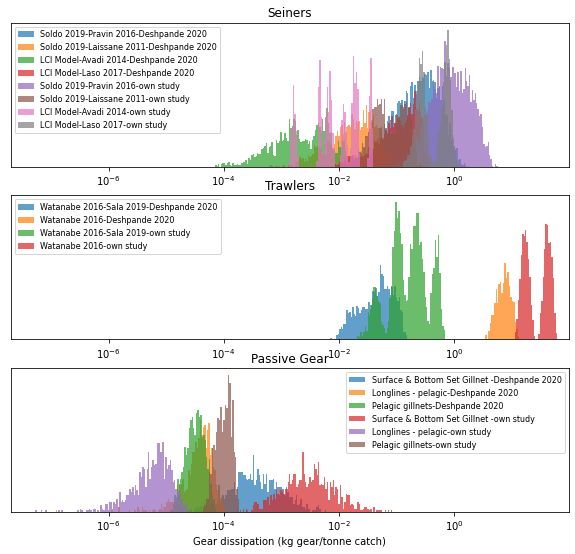

In [96]:
make_gear_model_plot(results, bind_min=2e-8)

In [16]:
# Run Monte Carlo simulation -- breaking out each stage as a separate dataset
internals = {'effort': defaultdict(list), 'gear': defaultdict(list), 'dissipation': defaultdict(list)}
mmap = dict()
for name, arg in models:
    for m in arg:
        internals['effort'][m.label].extend([m.e_tilde() * m.op_factor for i in range(1000)])
        internals['gear'][m.label].extend([m.g_tilde() * m.scaling_factor for i in range(1000)])
        internals['dissipation'][m.label].extend([m.d_tilde() for i in range(1000)])
        mmap[m.label] = m


In [17]:
mmap

{'Soldo 2019-Pravin 2016-Gilman 2020-pre': <gear_models.query.GearModel at 0x7fbd8aee0ee0>,
 'Soldo 2019-Pravin 2016-Deshpande 2020': <gear_models.query.GearModel at 0x7fbd8aee6160>,
 'Soldo 2019-Laissane 2011-Gilman 2020-pre': <gear_models.query.GearModel at 0x7fbd8aee0a60>,
 'Soldo 2019-Laissane 2011-Deshpande 2020': <gear_models.query.GearModel at 0x7fbd8aee0ca0>,
 'LCI Model-Losa 2018-Gilman 2020-pre': <gear_models.query.GearModel at 0x7fbd8aee9280>,
 'LCI Model-Losa 2018-Deshpande 2020': <gear_models.query.GearModel at 0x7fbd8aee94c0>,
 'LCI Model-Avadi 2014-Gilman 2020-pre': <gear_models.query.GearModel at 0x7fbd8aee9700>,
 'LCI Model-Avadi 2014-Deshpande 2020': <gear_models.query.GearModel at 0x7fbd8aee9940>,
 'Watanabe 2016-Sala 2019-Gilman 2020-pre': <gear_models.query.GearModel at 0x7fbd8aef5460>,
 'Watanabe 2016-Sala 2019-Deshpande 2020': <gear_models.query.GearModel at 0x7fbd8aef5580>,
 'Watanabe 2016-Gilman 2020-pre': <gear_models.query.GearModel at 0x7fbd8aeef580>,
 'Wata

# Manuscript Table 2

In [18]:
def _p_20_80(_dat):
    j = sorted(_dat)
    l = len(j)
    return j[floor(l*0.2)], j[ceil(l*0.8)]

In [19]:
def _model_performance(_nam):
    _gt, _rd = next((k, v) for k, v in results if _nam in v)
    fam = mmap[_nam].family
    _ge_nam = fam[0]
    if fam[1] == fam[0]:
        _ge_nam = fam[0]
    else:
        _ge_nam = '%s-%s' % (fam[:2])
    _gt_nam = _gt.split(' ')[0]
    return({
        'Model': _ge_nam,
        'Gear type': _gt_nam,
        'Effort-20-80': '%.3g--%.3g' % _p_20_80(internals['effort'][_nam]),
        'Gear-20-80': '%.3g--%.3g' % _p_20_80(internals['gear'][_nam]),
        'Dissip.': fam[2][0],
        'pct-20-80': '%.3g--%.3g' % tuple(100 * k for k in _p_20_80(internals['dissipation'][_nam])),
        'Result-20-80': '%.3g--%.3g' % _p_20_80(_rd[_nam]),
    })

In [20]:
table_2 = pd.DataFrame([_model_performance(m) for m in mmap.keys()])

In [21]:
table_2

,Model,Gear type,Effort-20-80,Gear-20-80,Dissip.,pct-20-80,Result-20-80
0,Soldo 2019-Pravin 2016,Seiners,0.135--1.97,15.2--175,G,2.29--6.67,0.441--1.8
1,Soldo 2019-Pravin 2016,Seiners,0.132--1.97,14.6--173,D,0.449--1.98,0.0902--0.493
2,Soldo 2019-Laissane 2011,Seiners,0.109--0.178,10.8--15.9,G,2.28--6.65,0.0387--0.138
3,Soldo 2019-Laissane 2011,Seiners,0.105--0.176,10.8--16,D,0.499--1.95,0.00747--0.0363
4,LCI Model-Losa 2018,Seiners,1--1,9.61--13,G,2.26--6.68,0.249--0.773
5,LCI Model-Losa 2018,Seiners,1--1,9.68--13,D,0.476--1.94,0.0529--0.216
6,LCI Model-Avadi 2014,Seiners,1--1,0.071--0.536,G,2.28--6.67,0.00463--0.0202
7,LCI Model-Avadi 2014,Seiners,1--1,0.0709--0.535,D,0.442--1.96,0.000853--0.00602
8,Watanabe 2016-Sala 2019,Trawlers,0.391--5.55,0.319--3.17,G,6.85--17.9,0.0898--0.323
9,Watanabe 2016-Sala 2019,Trawlers,0.387--5.53,0.314--3.21,D,2.38--3.82,0.0226--0.0828


In [22]:
print(table_2.to_latex(index=False))

\begin{tabular}{lllllll}
\toprule
                    Model & Gear type &        Effort-20-80 &       Gear-20-80 & Dissip. &    pct-20-80 &        Result-20-80 \\
\midrule
   Soldo 2019-Pravin 2016 &   Seiners &         0.135--1.97 &        15.2--175 &       G &   2.29--6.67 &          0.441--1.8 \\
   Soldo 2019-Pravin 2016 &   Seiners &         0.132--1.97 &        14.6--173 &       D &  0.449--1.98 &       0.0902--0.493 \\
 Soldo 2019-Laissane 2011 &   Seiners &        0.109--0.178 &       10.8--15.9 &       G &   2.28--6.65 &       0.0387--0.138 \\
 Soldo 2019-Laissane 2011 &   Seiners &        0.105--0.176 &         10.8--16 &       D &  0.499--1.95 &     0.00747--0.0363 \\
      LCI Model-Losa 2018 &   Seiners &                1--1 &         9.61--13 &       G &   2.26--6.68 &        0.249--0.773 \\
      LCI Model-Losa 2018 &   Seiners &                1--1 &         9.68--13 &       D &  0.476--1.94 &       0.0529--0.216 \\
     LCI Model-Avadi 2014 &   Seiners &               

# Side work


## List Quantities

In [25]:
gml._q

{'catch': <gear_models.quantities.QuantityGroup at 0x7fbdcced4430>,
 'scaling': <gear_models.quantities.QuantityGroup at 0x7fbdcced4dc0>,
 'operation': <gear_models.quantities.QuantityGroup at 0x7fbd8af77070>}

In [35]:
qs = list(t for k,v in gml._q.items() for t in v.entries)

In [39]:
for q in qs:
    print('%9s, %50s, %s' % (q.measure, q, q.unit))

    catch,                                  One tonne capture, tC
    catch,                             One tonne landed catch, t
  scaling,                       Effort for one tonne capture, t-eff
  scaling,                  Effort for one tonne landed catch, t-eff
  scaling,                                    Enclosed volume, m3
  scaling,                            Gross Tonnage of vessel, GT
  scaling,                        Kilowatt of engine capacity, kW
  scaling,                                     Length of line, m-line
  scaling,                                    Number of hooks, hooks
  scaling,                                Square meter of net, m2
  scaling,                            Vessel length in meters, m
  scaling,                                   kilometer of net, km
operation,                                   Catch life cycle, vlc
operation,                                   Day of operation, d
operation,                                        Fishing day, df

## List Model Components

In [54]:
listed_comps = list(set(k for k in gml.gear_models()).union(set(k for k in gml.effort_models()).union(set(k for k in gml.dissipation_models()))))

In [70]:
# correct mis-named reference
for c in listed_comps:
    if c.family == 'Losa 2018':
        c.family = 'Laso 2017'

In [95]:
# Template code for renaming result sets without re-running simulation
import re

for _, res_dict in results:
    ok = list(filter(lambda x: re.search('Gilman', x), res_dict.keys()))
    nk = [re.sub('Gilman 2020-pre', 'own study', x) for x in ok]
    for i, k in enumerate(ok):
        res_dict[nk[i]] = res_dict.pop(k)

In [59]:
# Show documentation string
print(listed_comps[0].doc)

source_name: Eco-efficiency assessment of the Peruvian anchoveta steel and wooden fleets using the LCA+DEA framework
source_doi: 10.1016/j.jclepro.2014.01.047
source_documentation: See also Freon et al 2014 [10.1007/s11367-014-0716-3]
Peru Anchoveta - Purse Seine LCI
Hand-writing JSON is not fun.
Scale by vessel capacity:
small: <10m3
medium: 27-32.6m3
vikingas: 50-100m3
industrial: 155-635
Note that Freon et al [10.1007/s11367-014-0716-3] is used for industrial vessels per author communication


In [61]:
# list of families
for f in sorted(set((k.family for k in listed_comps)):
    print(f)

Akyol 2012
Avadi 2014
Deshpande 2020
Gabr 2012
Gilman 2020-pre
Grimaldo 2019
Hoffman 2009
LCI Model
Laissane 2011
Losa 2018
Pravin 2016
Sala 2019
Soldo 2019
Watanabe 2016
